# AG News Classification
# Brief:

This notebook performs news article classification on the AG News dataset to categorize articles into topics such as World, Sports, Business, and Sci/Tech. It includes:



1.  Loading and exploring the AG News dataset using Pandas.
2.  Performing EDA (Exploratory Data Analysis) to understand class distribution and text lengths.
3.  Cleaning and preprocessing text (lowercasing, removing stopwords, tokenization, lemmatization).
4.  Visualizing the most frequent words per category using word clouds.
5.  Vectorizing text using TF-IDF vectorizer.
6.  Training and evaluating a Support Vector Machine (SVM) classifier for multiclass classification.
















Tools used: Pandas, NLTK, Scikit-learn, Matplotlib, Seaborn, Word2Vec (Gensim).

In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 541.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requi

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### Loading and exploring the AG News dataset using Pandas.

In [3]:
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
data.drop("Title", axis=1, inplace=True)
test_data.drop("Title", axis=1, inplace=True)

label_map = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
data["Category"] = data["Class Index"].map(label_map)

In [4]:
test_data.sample(10)

,Class Index,Description
1330,3,A decline in the price of oil helped lift US s...
5678,3,"Stocks extended their rally on Friday, led by ..."
3639,2,Nykesha Sales smiled when someone suggested th...
179,2,AMSTERDAM Cyclist Leontien Zijlaard-Van Moors...
4458,2,The first at-bat of the game seemed to go on a...
2942,2,Jerome Williams pitched seven innings in his f...
3318,2,"St Andrews, Oct 07 - Vijay Singh thinks the ma..."
2708,4,NEW YORK (AP) -- In a harbinger of security th...
5847,4,&lt;strong&gt;Analysis&lt;/strong&gt; That'll ...
6725,3,NEW YORK (Reuters) - U.S. stocks rose on Wedn...


### EDA (Exploratory Data Analysis) to understand class distribution and text lengths.

In [5]:
print("Dataset shape:", data.shape)
print("\nMissing values:\n", data.isna().sum())
print("\nDuplicate texts:", data.duplicated(subset=["Description"]).sum())

Dataset shape: (120000, 3)

Missing values:
 Class Index    0
Description    0
Category       0
dtype: int64

Duplicate texts: 1277


In [6]:
conflicts = data[data.duplicated(subset=["Description"], keep=False)].sort_values("Description")
conflicts.head(20)

,Class Index,Description,Category
620,3,(Clint Willis is a freelance writer who cover...,Business
19715,3,(Clint Willis is a freelance writer who cover...,Business
26121,3,"ALEXANDRIA, Va. (Reuters) - US Airways Group ...",Business
26013,3,"ALEXANDRIA, Va. (Reuters) - US Airways Group ...",Business
71472,3,"AMSTERDAM (Reuters) - Lakshmi Mittal, one of ...",Business
71700,3,"AMSTERDAM (Reuters) - Lakshmi Mittal, one of ...",Business
10740,4,AMSTERDAM (Reuters) - Mobile phone giants Vod...,Sci/Tech
10572,4,AMSTERDAM (Reuters) - Mobile phone giants Vod...,Sci/Tech
71586,4,AMSTERDAM (Reuters) - Mobile phone users arou...,Sci/Tech
71585,4,AMSTERDAM (Reuters) - Mobile phone users arou...,Sci/Tech


In [9]:
data.drop_duplicates(subset=["Description"], inplace=True)
print("\nDuplicate texts:", data.duplicated(subset=["Description"]).sum())


Duplicate texts: 0


In [10]:
class_counts = data["Category"].value_counts().sort_index()
class_percent = (class_counts / len(data) * 100).round(2)
pd.DataFrame({"count": class_counts, "percent": class_percent})

,count,percent
Category,,
Business,29613,24.94
Sci/Tech,29521,24.87
Sports,29834,25.13
World,29755,25.06


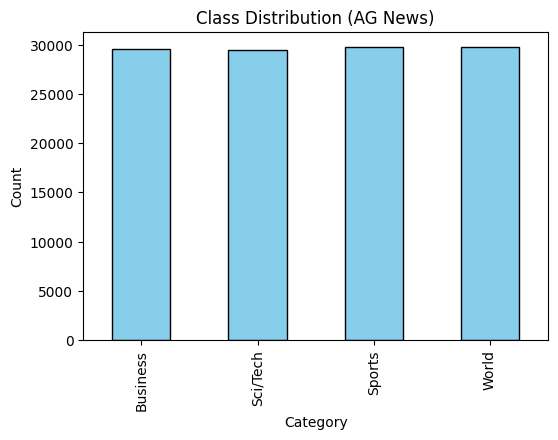

In [11]:
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Class Distribution (AG News)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


Length stats per category:
          char_len                                                word_len  \
            count   mean   std   min    25%    50%    75%    max    count   
Category                                                                    
Business  29613.0  198.5  62.8  48.0  161.0  192.0  221.0  974.0  29613.0   
Sci/Tech  29521.0  194.2  80.9  20.0  148.0  187.0  221.0  985.0  29521.0   
Sports    29834.0  185.2  48.7   6.0  152.0  179.0  209.0  841.0  29834.0   
World     29755.0  195.6  60.1  40.0  158.0  195.0  224.0  826.0  29755.0   

                                                    
          mean   std  min   25%   50%   75%    max  
Category                                            
Business  30.7   7.8  4.0  26.0  30.0  35.0  131.0  
Sci/Tech  30.6  12.2  3.0  24.0  30.0  36.0  173.0  
Sports    31.4   8.6  1.0  26.0  30.0  36.0  149.0  
World     31.6   9.8  6.0  26.0  31.0  36.0  139.0  


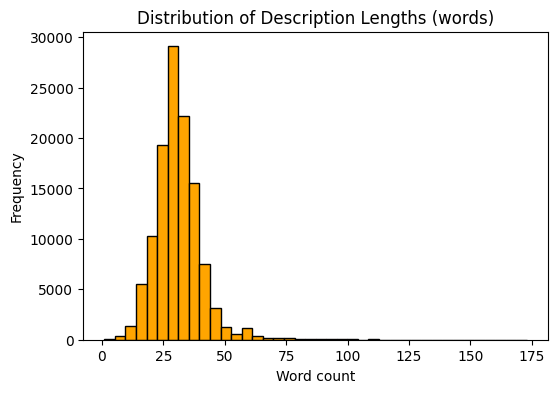

In [12]:
data["char_len"] = data["Description"].str.len()
data["word_len"] = data["Description"].str.split().str.len()

print("\nLength stats per category:\n",
      data.groupby("Category")[["char_len","word_len"]].describe().round(1))

# Histogram of lengths
plt.figure(figsize=(6,4))
plt.hist(data["word_len"], bins=40, color="orange", edgecolor="black")
plt.title("Distribution of Description Lengths (words)")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()

<Figure size 600x400 with 0 Axes>

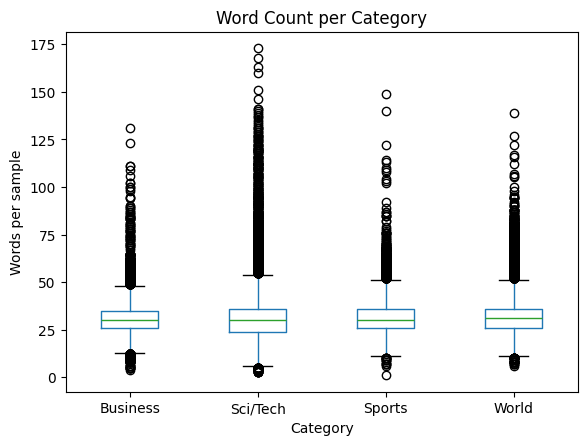

In [13]:
# Boxplot per category
plt.figure(figsize=(6,4))
data.boxplot(column="word_len", by="Category", grid=False)
plt.title("Word Count per Category")
plt.suptitle("")
plt.ylabel("Words per sample")
plt.show()

### Cleaning and preprocessing text (lowercasing, removing stopwords, tokenization, lemmatization).

In [14]:
stop_words = set(stopwords.words("english")) - {"not", "no", "nor", "never"}
lemmatizer = WordNetLemmatizer()

In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

In [16]:
data["clean_Description"] = data["Description"].apply(preprocess_text)
test_data["clean_Description"] = test_data["Description"].apply(preprocess_text)
data[["Description", "clean_Description"]].head()

,Description,clean_Description
0,"Reuters - Short-sellers, Wall Street's dwindli...",reuters short seller wall street dwindling ban...
1,Reuters - Private investment firm Carlyle Grou...,reuters private investment firm carlyle group ...
2,Reuters - Soaring crude prices plus worries\ab...,reuters soaring crude price plus worry economy...
3,Reuters - Authorities have halted oil export\f...,reuters authority halted oil export flow main ...
4,"AFP - Tearaway world oil prices, toppling reco...",afp tearaway world oil price toppling record s...


### Visualizing the most frequent words per category using word clouds.

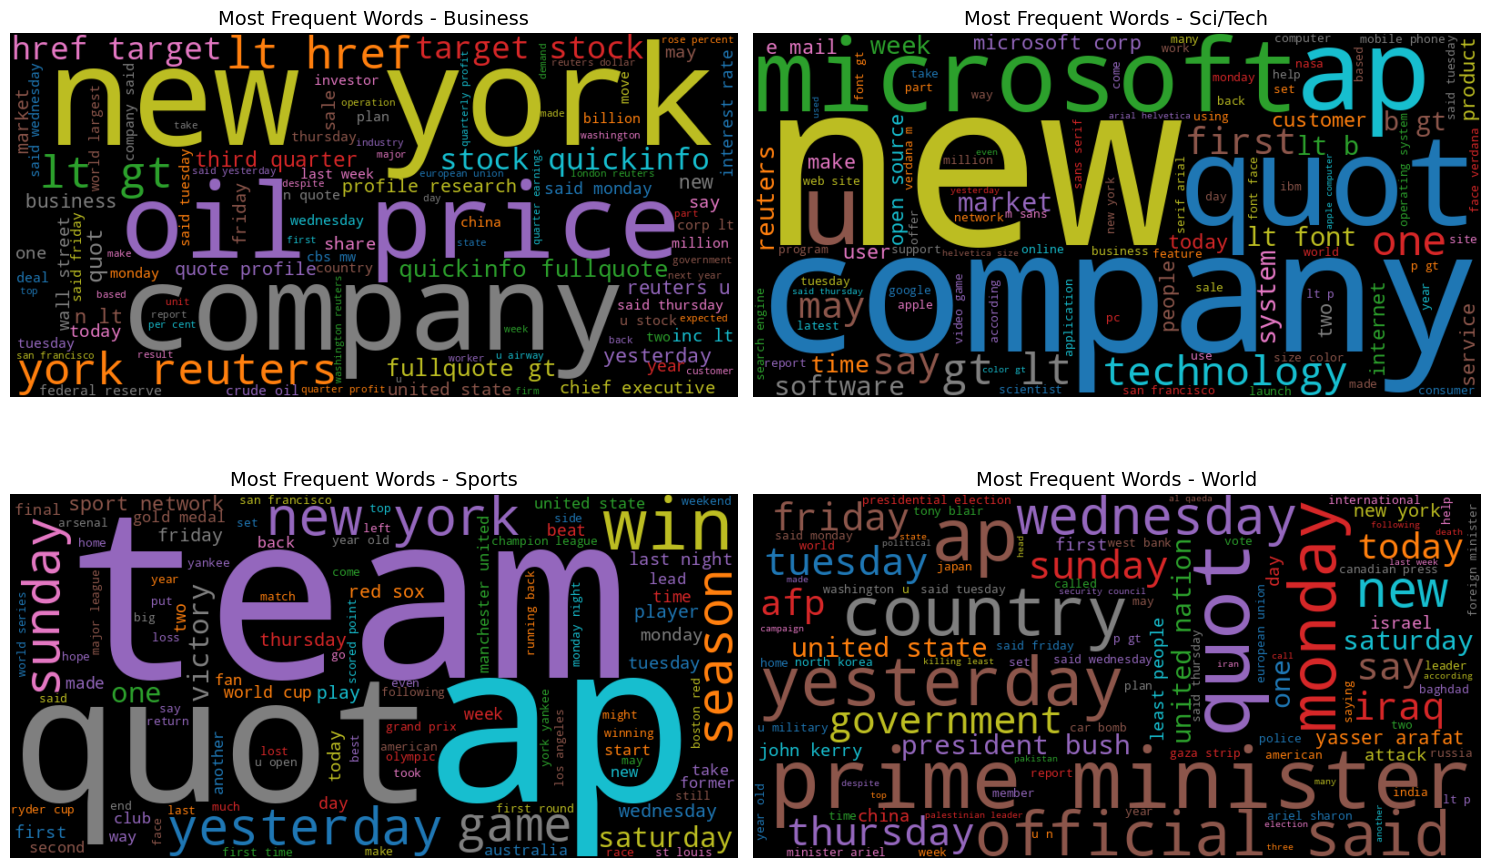

In [17]:
categories = data['Category'].unique()

plt.figure(figsize=(15, 10))

for i, category in enumerate(categories, 1):
    text = " ".join(data[data['Category'] == category]['clean_Description'])

    wc = WordCloud(width=800, height=400, background_color="black",
                   max_words=100, colormap="tab10").generate(text)

    # Plot
    plt.subplot(2, 2, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Most Frequent Words - {category}", fontsize=14)

plt.tight_layout()
plt.show()


### Vectorizing text using TF-IDF vectorizer.

In [36]:
tfidf = TfidfVectorizer(max_features=10000,
                        ngram_range=(1,3),
                        stop_words="english")

In [41]:
X_train = tfidf.fit_transform(data['Description'])
X_test  = tfidf.transform(test_data['Description'])
y_train = data["Class Index"]
y_test = test_data["Class Index"]

### Training and evaluating a Support Vector Machine (SVM) classifier



In [42]:
linear_svc = LinearSVC(C=1.0, max_iter=5000, random_state=42)
linear_svc.fit(X_train, y_train)

LinearSVC(max_iter=5000, random_state=42)

In [43]:
y_pred = linear_svc.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9055



Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.90      0.91      1900
           2       0.95      0.97      0.96      1900
           3       0.87      0.87      0.87      1900
           4       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



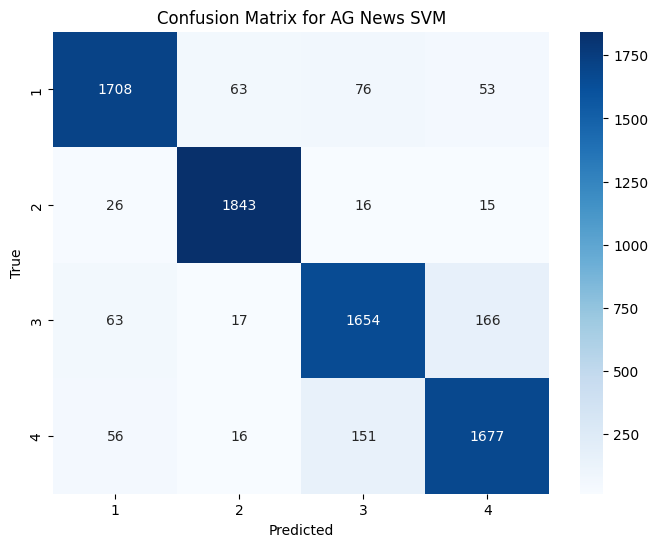

In [44]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=linear_svc.classes_,
            yticklabels=linear_svc.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for AG News SVM")
plt.show()

In [49]:
class_mapping = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}
def predict_category(text):
    clean_text = preprocess_text(text)
    text_tfidf = tfidf.transform([clean_text])
    pred = linear_svc.predict(text_tfidf)[0]
    return class_mapping[pred]

In [50]:
user_input = input("Enter a news article or headline: ")
category = predict_category(user_input)
print("Predicted category:", category)

Enter a news article or headline: The stock market saw a significant rise in technology shares today.
Predicted category: Sci/Tech


# End

Author: Omar Atef Ahmed

Task: Second Task - AG News Classification

GitHub: https://github.com/k8onl

LinkedIn: https://www.linkedin.com/in/k8onl
